<a href="https://colab.research.google.com/github/ceyxasm/ISRO_XSM_analyser/blob/main/XSM_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from google.colab import drive

In [59]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


# image_file = get_pkg_data_filename('/content/ch2_xsm_20211111_v1_level1.fits')
from astropy.utils.data import download_file
image_file = fits.open('/content/ch2_xsm_20210917_v1_level2.lc')
image_file2 = fits.open('/content/ch2_xsm_20210923_v1_level2.lc')
image_file3 = fits.open('/content/ch2_xsm_20211108_v1_level2.lc')



In [60]:
img_data=image_file[1].data
img_data2=image_file2[1].data
img_data3=image_file3[1].data


In [ ]:
def denoise(signal , kernel_size):
  #signal       :signal to be denoised
  #kernel_size  :the size of kernel used to denoised

  kernel= np.empty(kernel_size, dtype=float)
  kernel.fill(1)
  kernel=kernel/kernel_size
  #kernel will be[0.33, 0.33, 0.33] for size 3 ; [0.2, 0.2, 0.2, 0.2, 0.2] for size 5

  pad_size= kernel_size//2
  padded_signal= np.zeros( 193+ 2*pad_size, dtype=float)
  for i in range(pad_size):
    padded_signal[i]= signal[0]
    padded_signal[-1-i]= signal[192]
  for i in range(193):
    padded_signal[pad_size+ i]= signal[i]


  denoised_signal= np.empty(193, dtype=float)
  for i in range(193):
    denoised_signal[i]= np.dot(padded_signal[i: i+ kernel_size], kernel)
  return denoised_signal

In [61]:
y=img_data['RATE']
x=img_data['TIME']

y1=img_data2['RATE']
x1=img_data2['TIME']

y2=img_data3['RATE']
x2=img_data3['TIME']



def biner(signal):
  z=[]
  for i in signal:
    if i> 800 and i<= 5011:
      z.append(1000) #type B
    elif i>5011 and i<= 25000:
      z.append(5000) #type C
    elif i>25000 and i<= 250000:
      z.append(25000) #type M
    elif i>2500000:
      z.append(250000) #type X
    elif i<=800: z.append(0) #inconclusive, could be A
  return z




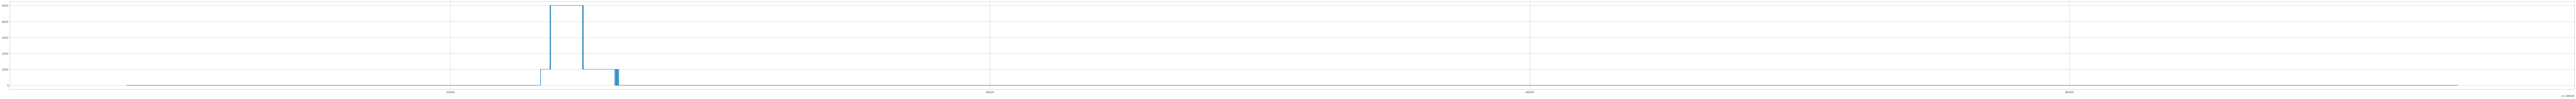

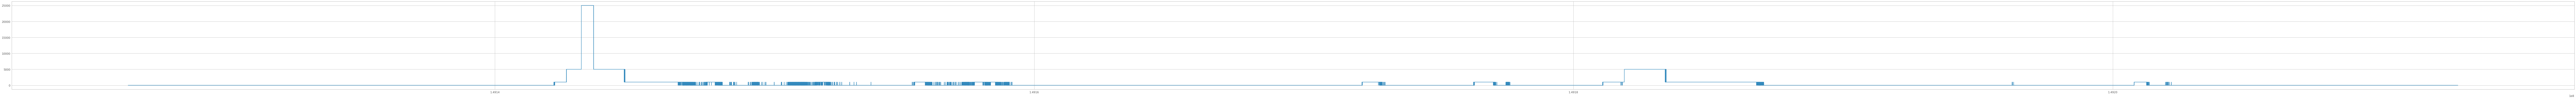

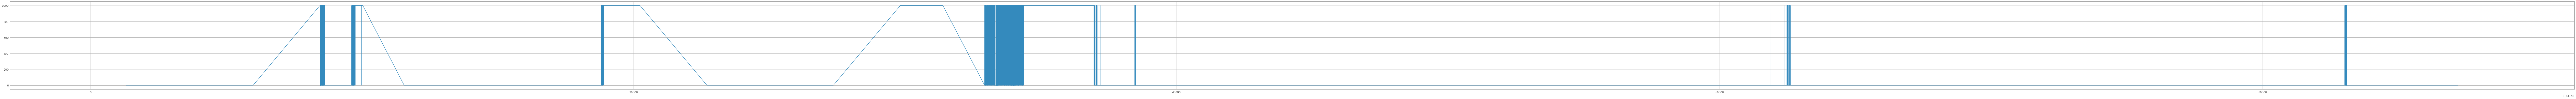

In [62]:
z=biner(y)
z1=biner(y1)
z2=biner(y2)

plt_1 = plt.figure(figsize=(200,7))
plt.plot(x, z)
plt.show()


plt_1 = plt.figure(figsize=(200,7))
plt.plot(x1, z1)
plt.show()


plt_1 = plt.figure(figsize=(200,7))
plt.plot(x2, z2)
plt.show()



In [63]:
def stable(signal):
  timer=0
  ts=0
  for i in range(len(signal)):
    if signal[i]!=0 and timer==0:
      ts=i
      timer=1
    if signal[i]==0 and timer==1:
      timer=0
      if i-ts<120:
        for j in range(ts, i+1):
          signal[j]=0

  return signal
  

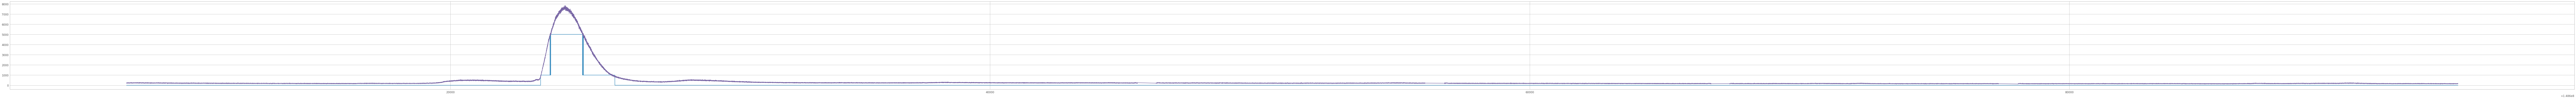

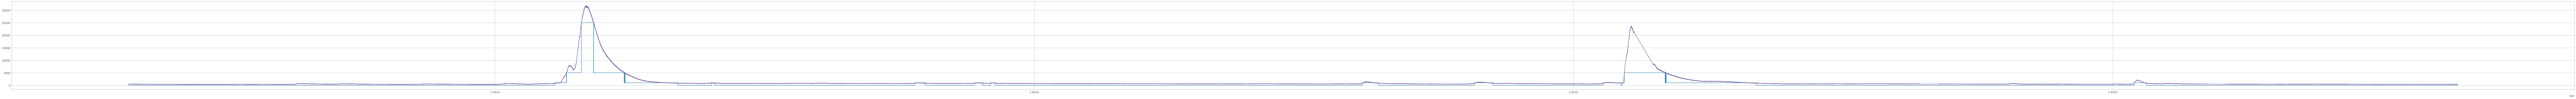

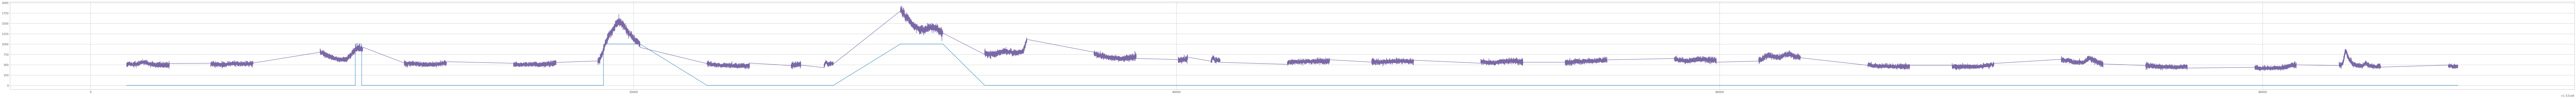

In [64]:
f= stable(z)
f1=stable(z1)
f2=stable(z2)

plt_1 = plt.figure(figsize=(200,7))
plt.plot(x, f)
plt.plot(x,y)
plt.show()


plt_1 = plt.figure(figsize=(200,7))
plt.plot(x1, f1)
plt.plot(x1,y1)
plt.show()


plt_1 = plt.figure(figsize=(200,7))
plt.plot(x2, f2)
plt.plot(x2,y2)
plt.show()


In [165]:
def extractor( signal, time):
  stable_signal= stable(biner(signal))
  t_start=[]
  i_start=[]

  start_flux=[]
  end_flux=[]
  
  t_stop=[]
  i_stop=[]

  peak_count=[]
  t_peak=[]
  i_peak=[]

  i_rise=[]
  t_rise=[]

  i_decay=[]
  t_decay=[]

  cat=[]
  timer=0
  for i in range(len(signal)):
    if stable_signal[i] >99 and timer==0:
      t_start.append(time[i])
      i_start.append(i)
      timer=1

    if stable_signal[i] <99 and timer==1:
      t_stop.append(time[i])
      i_stop.append(i)
      timer=0
      if t_start==[]:
        t_start.append(0)
        i_start.append(0)


  for i in range(len(t_start)):
    peak_count_val=0
    peak_instance=0
    for index in range(i_start[i], i_stop[i]):
      if peak_count_val< signal[index]:
        peak_count_val= signal[index]
        peak_instance= index

    peak_count.append( peak_count_val )
    t_peak.append( time[peak_instance])
    i_peak.append(peak_instance)

    bin_max= max(stable_signal[i_start[i]: i_stop[i]])
    if bin_max==1000: cat.append('B')
    elif bin_max==5000: cat.append('C')
    elif bin_max==25000: cat.append('M')
    elif bin_max==250000: cat.append('X')

  # for i in range(len(t_start)):
  #   up_thresh=  signal[i_peak[i]]/20
  #   down_thresh=  signal[i_peak[i]]/2
  #   start_flux.append(up_thresh)
  #   end_flux.append(down_thresh)

  for i in range(len(t_start)):
    start_t, end_t, start_i, end_i=t_peak[i], t_peak[i], i_peak[i], i_peak[i]
    while( signal[start_i]> peak_count[i]/20 and start_i>i_start[i]):
      start_i-=1
    while( signal[end_i]> peak_count[i]/2 and end_i<i_stop[i]):
      end_i+=1
    i_rise.append(start_i)
    i_decay.append(end_i)
    t_rise.append( time[start_i] )
    t_decay.append( time[end_i] )
  
  data={
      't_start': t_start,
      't_stop': t_stop,
      'category': cat,
      'peak count rate': peak_count,
      'peak instance': t_peak,
      'rise instance': t_rise,
      'decay instance': t_decay,
      'i_start': i_start,
      'i_stop': i_stop,
      'i_peak': i_peak,
      'i_rise': i_peak,
      'i_decay': i_decay,
  }


  return data



In [163]:
data= extractor(y, x)
t_start= data['t_start']
t_stop= data['t_stop']
t_peak= data['peak time']
t_rise= data['rise instance']
t_decay= data['decay instance']
cat= data['category']
len(t_stop)

1

In [164]:
for i in range(1):
  print( t_rise[i]-t_peak[i], t_peak[i]-t_decay[i], t_start[i]-t_peak[i], t_peak[i]-t_stop[i], cat[i])

-915.0 -840.0 -915.0 -1836.0 C


In [80]:
data['category']

['M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'B']

In [107]:
data['peak time']

[array([1.49127579e+08]),
 array([1.49126474e+08]),
 array([1.49126526e+08]),
 array([1.49126495e+08]),
 array([1.49126491e+08]),
 array([1.49126568e+08]),
 array([1.49126596e+08]),
 array([1.49126631e+08]),
 array([1.4912675e+08]),
 array([1.49126522e+08])]

In [111]:
aq = y[0]-191.50723
if(aq<0.000001):
  print("true")

In [126]:
yj=np.around(y, 3)

In [128]:
aq = y[0]-191.507
if(aq<0.001):
  print("true")


true


In [166]:
type(x)

numpy.ndarray